<a href="https://colab.research.google.com/github/vivekshaoutlook/machine_learning/blob/master/06_Ensemble_and_Stacking_on_Titanic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [230]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [0]:
import xgboost as xgb

In [232]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_train.csv")

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_test.csv")

In [235]:
train.shape

(891, 12)

In [236]:
test.shape

(418, 11)

In [0]:
full_data = [train,test]

**SECTION1: CLEANING AND FEATURE ENGINEERING**

In [0]:
#feature engineering
#F1. new feature - name_length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)


In [0]:
#F2.new feature - "Has_Cabin".whether the passenger had a cabin
train["Has_cabin"] = train["Cabin"].isnull().astype(int)
test["Has_cabin"] = test["Cabin"].isnull().astype(int)

In [0]:
#F3.new feature: Family_size 
#instead of seprately adding new columns, like we did above, we can also use the full_data array
#the plus 1 in the end includes the passenger himeself/herself :)
for dataset in full_data:
  dataset["Family_size"] = dataset['SibSp'] + dataset['Parch'] + 1


In [0]:
#F4.new feature-IsAlone. a Was the person traveling alone
for dataset in full_data:
  dataset["IsAlone"]=0 # create a new column "IsAlone" and initialize it to 0
  dataset.loc[dataset["Family_size"]==1,"IsAlone"]=1 #set the "IsAlone" column to 1 where the Family_Size=1


In [242]:
print(train["Embarked"].value_counts())
print(test["Embarked"].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [0]:
#C1.Cleaning.Since majority of people have embarked from port S, we can default S for missing values
for dataset in full_data:
  dataset["Embarked"] = dataset["Embarked"].fillna("S")
 

In [244]:
#verify that now no missing values in Embarked column
print(train["Embarked"].isna().sum())
print(test["Embarked"].isna().sum())

0
0


In [0]:
#C2.Filling missing fare with the median 
for dataset in full_data:
  dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
  

In [0]:
#F5.creating a new  categorical feature - CategoricalFare
train["CategoricalFare"] = pd.qcut(train['Fare'], 4)

In [247]:
#let's see what range(bucket) got created and how many values in each range
train["CategoricalFare"].value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: CategoricalFare, dtype: int64

In [0]:
#C3.filling missign Age
for dataset in full_data:
 avg_age = np.mean(dataset["Age"])
 std_dev_of_age = np.std(dataset["Age"])
 missing_age_count = np.isnan(dataset["Age"]).sum()
 missing_age_random_list = np.random.randint(avg_age-std_dev_of_age,avg_age+std_dev_of_age,missing_age_count)
 dataset['Age'][np.isnan(dataset['Age'])] = missing_age_random_list
 dataset['Age'] = dataset['Age'].astype(int)




In [0]:
#F6.Creating a new categorical feature - CategoricalAge
train["CategoricalAge"] = pd.cut(train["Age"],5)


In [250]:
#let's see what range(bucket) got created and how many values in each range
train["CategoricalAge"].value_counts()

(16.0, 32.0]     447
(32.0, 48.0]     252
(-0.08, 16.0]    112
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: CategoricalAge, dtype: int64

In [0]:
#F7: create a new feature-Title
def get_title(name):
  title_text = re.search('([A-Za-z]+)\.',name)
  if title_text:
    return  title_text.group()
  else:
    return ""
  
for dataset in full_data:
  dataset["Title"] = dataset["Name"].apply(get_title)

In [252]:
train["Title"].value_counts()


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Mme.           1
Capt.          1
Jonkheer.      1
Sir.           1
Don.           1
Lady.          1
Ms.            1
Countess.      1
Name: Title, dtype: int64

In [0]:
 #C4: replace less common titles with a single title "Rare"
 rare_title = ['Lady.', 'Countess.','Capt.', 'Col.','Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.']
 for dataset in full_data:
   dataset["Title"] = dataset["Title"].replace(rare_title,"Rare.")
   dataset['Title'] = dataset['Title'].replace('Mlle.', 'Miss.')
   dataset['Title'] = dataset['Title'].replace('Ms.', 'Miss.')
   dataset['Title'] = dataset['Title'].replace('Mme.', 'Mrs.')


In [254]:
#let's verify that the titles have been reduced as desired
train["Title"].value_counts()

Mr.        517
Miss.      185
Mrs.       126
Master.     40
Rare.       23
Name: Title, dtype: int64

In [255]:
test["Title"].value_counts()

Mr.        240
Miss.       79
Mrs.        72
Master.     21
Rare.        6
Name: Title, dtype: int64

In [0]:
#C5: the grand cleaning by converting all categorical to numerical
for dataset in full_data:
  sex_mapping_dict = {'female': 0, 'male': 1}
  titles_mapping_dict = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  embarked_port_dict = {'S': 0, 'C': 1, 'Q': 2}
    
  dataset["Sex"] = dataset["Sex"].map(sex_mapping_dict).astype(int)
  dataset["Title"] = dataset["Title"].map(titles_mapping_dict)
  dataset["Title"] = dataset["Title"].fillna(0)#still if few titles are not filled, replace those with 0
  dataset["Title"] = dataset["Title"].astype(int)
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  #fare cleaning
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  #age cleaning
  dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4





In [257]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_cabin,Family_size,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,1,2,0,"(-0.001, 7.91]","(16.0, 32.0]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,0,2,0,"(31.0, 512.329]","(32.0, 48.0]",0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,1,1,1,"(7.91, 14.454]","(16.0, 32.0]",0


In [0]:
#F8: remove unwanted features
#PassengerId: nothing useful here
#Name: we already extracted title and name length.
#Ticket: nothing useful here
#Cabin:already created a new feature - "has_cabin"
#SibSp: already created a new feature - "Family_size". "Parch" still be useful becasue Family_Size - Parch = SibSp
passengerId_for_submission = test["PassengerId"]
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Name_length']
train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)
#since CategoricalAge and CategoricalFare related information is now captured in Fare and Age column, can drop these too
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1) #was added only in train set



SECTION2: DATA VISUALIZATION

In [259]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_cabin,Family_size,IsAlone,Title
0,0,3,1,1,0,0,0,1,2,0,0
1,1,1,0,2,0,3,1,0,2,0,0
2,1,3,0,1,0,1,0,1,1,1,0


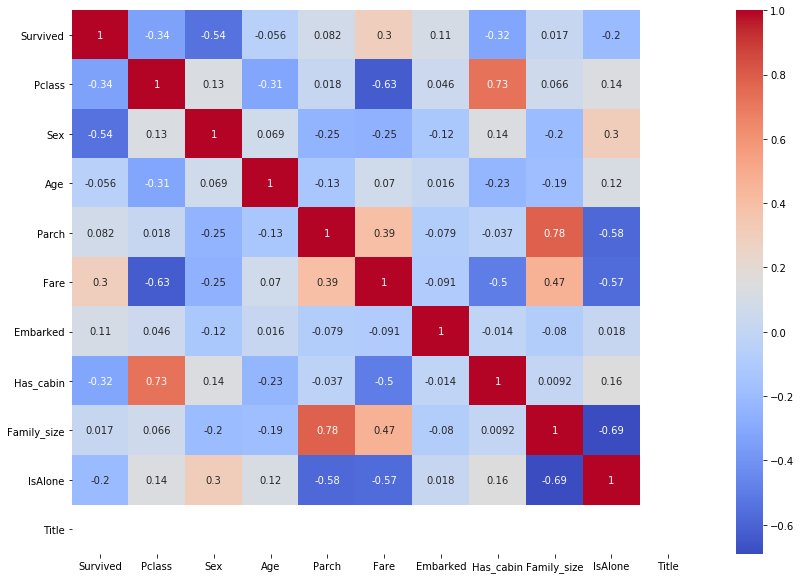

In [260]:
#V1. let's plot heat map to see the correlation among different features
plt.figure(figsize=(14,10))
tc = train.corr()
sns.heatmap(tc,annot=True,cmap = "coolwarm")

In [0]:
#takeaway from heatmap = most of the features are uncorrelated (parch-family_size & Has_cabin-pclass has some correlation though.
#This can be refined further). Uncorrelation among features is good becasue we are not going to pass any redundant feature
#in the model i.e. each feature is gong to provide unique information

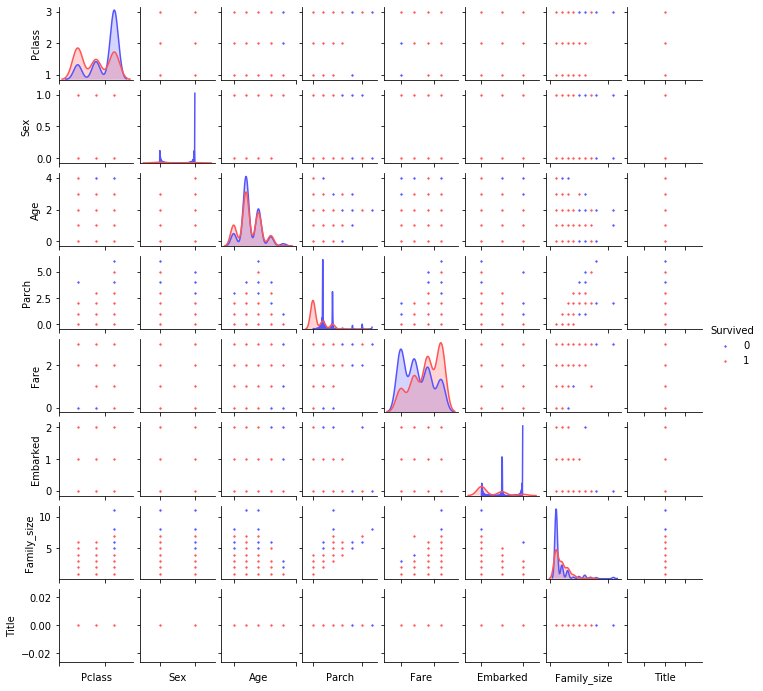

In [262]:
g = sns.pairplot(train[['Survived','Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Family_size', 'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

**SECTION3: ENSEMBLING AND STACKING**

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED,shuffle=False)#though shuffle is 'False" by default itself

In [0]:
# Class to extend the Sklearn classifier
class SKLearnHelper(object):
  #the first argument in constructor (normally called 'self') is used to access instance varaibles.
  #Other subsequent arguments are instance varaibles
  def __init__(self,clf,seed=0,params=None):  
    params['random_state'] = seed#add 'random_state' to the dictionary - 'params'
    self.clf = clf(**params)#pass the arguments to the classifier-clf-by unpacking (**) the dictionary - 'params'
  
  def train(self, x_train, y_train):#note that first argument is 'self' just like the constructor.x_train, y_train are instance varaibles
        self.clf.fit(x_train, y_train) #instance variables are always accessed by 'self'(name of the varaible which was first argument of the constrcutor )
  def predict(self, x):
        return self.clf.predict(x)
  def fit(self,x,y):
        return self.clf.fit(x,y)
  def feature_importances(self,x,y):
  ###def feature_importances(self):
        return self.clf.fit(x,y).feature_importances_
        ###return self.clf.feature_importances_

In [0]:
# TODO:can have a similar Class to extend XGboost classifier

In [0]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500, #number of tress in the forest
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6, #max depth of the tree
    'min_samples_leaf': 2,#min number of samples a leaf node must have

    #max number of features that are evaluated for splitting at each node.Here: sqrt(n_features). this is default actually.
    #n_features: The number of features when fit is performed.
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }




In [0]:
rf = SKLearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SKLearnHelper(clf = ExtraTreesClassifier,seed=SEED, params=rf_params)
ada = SKLearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SKLearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SKLearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [0]:
#create numpy arrays out of training and test datasets for use in classifier
y_train = train['Survived'].ravel() #equivalent to- train['PClass'].reshape(-1)
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data

In [0]:
#calculate and return oof(out-of-fold) prediction of train and test dataset
def get_oof(clf, x_train, y_train, x_test):
    fi = []

    oof_train = np.zeros((ntrain,))#1d array with number of entries = number of rows in train dataset
    oof_test = np.zeros((ntest,))#1d array with number of entries = number of rows in test dataset
    oof_test_skf = np.empty((NFOLDS, ntest))#holds the prediction of each test set by each cl
    #i=0
    #for train_index, test_index in kf.split(x_train):
    for i,(train_index,test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)#train on 80% of train dataset (k=5, so train on 80%, remaining 20% fold of train dataset is used for 'cv test' dataset)

        oof_train[test_index] = clf.predict(x_te)#make prediction for the 20% of train dataset which is used as cv test dataset and save the prediction

        #make the prediction for the original test dataset, there will be 5 (NFOLDS value) predictions  for each data point in original test dataset
        #we will take a mean of these 5 values after the loop is over
        oof_test_skf[i, :] = clf.predict(x_test)

        #i+=i

    oof_test[:] = oof_test_skf.mean(axis=0)
    
    try:
       #this try-except block helps when clf is SVC becasue SVC does not have feature_importances_
       ###fi.append( clf.feature_importances())
       fi.append( clf.feature_importances(x_train,y_train))
    except:
      print("An exception becasue SVC does not have feature_importances_ attribute")


    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1),fi #convert row vector into column vector by .reshape(-1,1)

***SECTION 3.1: First Level Prediction***

In [270]:
#get the oof train and test predictions. these will be used as new features for the next level of stacking
feature_importance = []

rf_oof_train, rf_oof_test,fi = get_oof(rf,x_train, y_train, x_test) # Random Forest
feature_importance.append(fi)

et_oof_train, et_oof_test,fi = get_oof(et, x_train, y_train, x_test) # Extra Trees
feature_importance.append(fi)

ada_oof_train, ada_oof_test,fi = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
feature_importance.append(fi)

gb_oof_train, gb_oof_test,fi = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
feature_importance.append(fi)

svc_oof_train, svc_oof_test,fi = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
#SVC object does not have feature_importances_

print("Training is complete")

An exception becasue SVC does not have feature_importances_ attribute
Training is complete


In [271]:
#let's do a sample printing for feature importance of random forest
###for name,score in zip(train.columns,rf.feature_importances()):
for name,score in zip(train.columns,rf.feature_importances(x_train,y_train)):
  print(name," ", score)

Pclass   0.1575373739443043
Sex   0.4111798224164568
Age   0.06239659883795506
Parch   0.032077325077181335
Fare   0.10852191905075514
Embarked   0.0346335356427158
Has_cabin   0.08645594718457984
Family_size   0.08492676812735667
IsAlone   0.02227070971869508
Title   0.0


In [272]:
#let's print out all the feature importance of all 4 classifiers (SVC is left out here)
#sequence is: Random Forest,Extra Trees,AdaBoost ,Gradient Boost
feature_importance

[[array([0.15753737, 0.41117982, 0.0623966 , 0.03207733, 0.10852192,
         0.03463354, 0.08645595, 0.08492677, 0.02227071, 0.        ])],
 [array([0.16817214, 0.4834881 , 0.02968863, 0.02037795, 0.08601449,
         0.02418475, 0.11480847, 0.03873362, 0.03453185, 0.        ])],
 [array([0.048, 0.022, 0.034, 0.632, 0.022, 0.024, 0.01 , 0.198, 0.01 ,
         0.   ])],
 [array([0.14833139, 0.45978914, 0.07295994, 0.03291128, 0.06455752,
         0.03481409, 0.06289685, 0.10153372, 0.02220607, 0.        ])]]

In [0]:
#let's create a DF using the feature importance for easily plotting using the plotly
cols = train.columns.values
feature_df = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': feature_importance[0][0],
     'Extra Trees  feature importances': feature_importance[1][0],
      'AdaBoost feature importances': feature_importance[2][0],
    'Gradient Boost feature importances': feature_importance[3][0]
    })

In [274]:
feature_df

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.157537,0.168172,0.048,0.148331
1,Sex,0.411180,0.483488,0.022,0.459789
2,Age,0.062397,0.029689,0.034,0.072960
3,Parch,0.032077,0.020378,0.632,0.032911
4,Fare,0.108522,0.086014,0.022,0.064558
5,Embarked,0.034634,0.024185,0.024,0.034814
6,Has_cabin,0.086456,0.114808,0.010,0.062897
7,Family_size,0.084927,0.038734,0.198,0.101534
8,IsAlone,0.022271,0.034532,0.010,0.022206
9,Title,0.000000,0.000000,0.000,0.000000


In [275]:
#TODO: this plotly graph is not working
trace = go.Scatter(
    y = feature_df['Random Forest feature importances'].values,
    x = feature_df['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_df['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_df['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_df['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [276]:
# Create the new column containing the average feature importance
feature_df['mean'] = feature_df.mean(axis= 1)
feature_df.sort_values(by=["mean"],ascending=False)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
1,Sex,0.411180,0.483488,0.022,0.459789,0.344114
3,Parch,0.032077,0.020378,0.632,0.032911,0.179342
0,Pclass,0.157537,0.168172,0.048,0.148331,0.130510
7,Family_size,0.084927,0.038734,0.198,0.101534,0.105799
4,Fare,0.108522,0.086014,0.022,0.064558,0.070273
6,Has_cabin,0.086456,0.114808,0.010,0.062897,0.068540
2,Age,0.062397,0.029689,0.034,0.072960,0.049761
5,Embarked,0.034634,0.024185,0.024,0.034814,0.029408
8,IsAlone,0.022271,0.034532,0.010,0.022206,0.022252
9,Title,0.000000,0.000000,0.000,0.000000,0.000000


***SECTION 3.2: Second Level Prediction***

In [277]:
base_predictions_train_df = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train_df.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


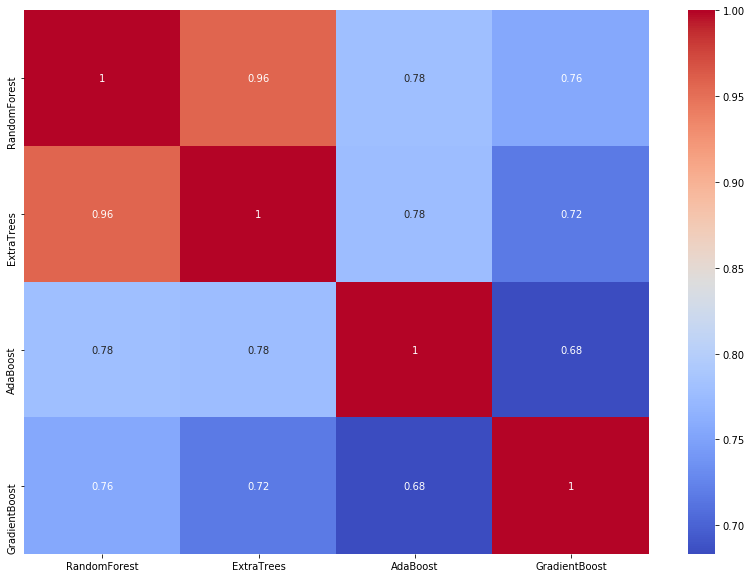

In [278]:
plt.figure(figsize=(14,10))
tc1 = base_predictions_train_df.corr()
sns.heatmap(tc1,annot=True,cmap = "coolwarm")

In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [0]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1)

gbm.fit(x_train, y_train)

predictions = gbm.predict(x_test)

In [281]:
predictions.shape

(418,)

In [0]:
submission = pd.DataFrame({"PassengerId":passengerId_for_submission,
                           "Survived":predictions})
submission.to_csv("/content/drive/My Drive/Colab Notebooks/titanic_survived_algo_stacking.csv",index=False)

END: SUBMISSION1 TO KAGGLE (score=0.76555)